In [1]:
# Something is wrong with jupyterlabs execution path
import os
os.chdir(os.path.dirname(os.path.abspath(".")))

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [34]:
from ConvLSTM import Seq2Seq
from DatasetOperations import SLADataset, Loss, DatasetParameters
import TrainingLoop
import SaveLoadModels

import tabulate
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

import xarray as xr
from datetime import date, datetime
from pathlib import Path
from typing import Type
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

from IPython import display

try:
    from ..Models import _types
    from ..Models.Regression.model import MetaRegression, Regression
except:
    from Models import _types
    from Models.Regression.model import MetaRegression, Regression

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print(f"Using: 'cuda:{torch.cuda.current_device()}'")
else:
    print("Using: cpu")
    DEVICE = torch.device("cpu")

BASEPATH = Path(r"Data/Grids/")
SAVEFOLDER = Path("SavedModels", "second_model")

SAVEFOLDER.mkdir(parents=True, exist_ok=True)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using: 'cuda:0'
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model

In [17]:
model, optimizer, last_loss, dataset_parameters = SaveLoadModels.load_checkpoint(
    SAVEFOLDER / "checkpoint_200.pkl",
    Seq2Seq,
    DEVICE
)

with open(SAVEFOLDER / "Regression.pkl", 'rb') as file:
    regressor = MetaRegression.load(file)

start_epoch = last_loss.epoch

In [18]:
print("Last Loss")
rms_train = np.sqrt(last_loss.training)*100
rms_val = np.sqrt(last_loss.validation)*100
print(f"Epoch: {start_epoch} Training Loss: {rms_train:.2f} cm Validation Loss: {rms_val:.2f} cm")

Last Loss
Epoch: 100 Training Loss: 8.37 cm Validation Loss: 8.68 cm


# Hyperparameters
This section should only be run if the paramaters was not loaded from a file

In [42]:
dataset_parameters = DatasetParameters(
    batch_size = 5,
    sequence_length = 5,
    sequence_steps = 5,
    prediction_steps = 30,
    fill_nan = 99,
    train_end = date(2014, 1, 1),
    validation_end = date(2019, 1, 1)
)
start_epoch = 0

# Load data

In [43]:
with xr.open_dataset(BASEPATH / "without_polar_v5_mss21.nc", engine="netcdf4") as file:
    file = file.sortby('time')
    sla = file['sla21'].data
    times = file['time'].data
    lat = file['Latitude'].data
    lon = file['Longitude'].data

# Fit trend and seasonality
This section should only be run if the regressor was not loaded from a file

In [26]:
# Create and fit model
function_kwargs = {"fit_type": ("poly", "fourier"), "period": 1, "deg": (1,1)}
regressor = MetaRegression(Regression, function_kwargs, 0)
regressor.fit(times, sla.reshape(sla.shape[0], -1))

# Save metaregressor
with open(SAVEFOLDER / "Regression.pkl", 'wb') as file:
    regressor.save(file)

# Setup data

In [44]:
sla -= regressor.predict(times).reshape(*sla.shape)

In [45]:
train_end = np.array(dataset_parameters.train_end).astype("datetime64[ns]")
validation_end = np.array(dataset_parameters.validation_end).astype("datetime64[ns]")

# Save times
bool_train = times <= train_end
bool_validation = (times > train_end) & (times <= validation_end)
bool_test = times > validation_end

train_time = times[bool_train].astype("datetime64[D]").astype(int)
validation_time = times[bool_validation].astype("datetime64[D]").astype(int)
test_time = times[bool_test].astype("datetime64[D]").astype(int)

# Save sla features
train_features = sla[bool_train]
validation_features = sla[bool_validation]
test_features = sla[bool_test]

In [46]:
# Kwargs to dataloaders
kwargs_dataloader = {
    'shuffle': False,
    'batch_size': dataset_parameters.batch_size
}

# Dataloders
train_loader = DataLoader(SLADataset(train_features, train_time, dataset_parameters), **kwargs_dataloader)
validation_loader = DataLoader(SLADataset(validation_features, validation_time, dataset_parameters), **kwargs_dataloader)
test_loader = DataLoader(SLADataset(test_features, test_time, dataset_parameters), **kwargs_dataloader)

# Get a batch
input_features, result, result_mask, time_features, result_time = next(iter(train_loader))

# Set frame size
frame_size = tuple(input_features.shape[-2:])

## Datasizes

In [47]:
tabulate.tabulate(
    [
        ["Sizes" ,"batch_size", "num_channels", "sequence length", "y_size", "x_size"],
        ["Input", *input_features.shape],
        ["Output", *result.shape[:1], None, None, *result.shape[1:]],
        ["Mask", *result_mask.shape[:1], None, None, *result_mask.shape[1:]]
    ],
    tablefmt='html'
)

Sizes,batch_size,num_channels,sequence length,y_size,x_size
Input,5,1,5,129,360
Output,5,,,129,360
Mask,5,,,129,360


# Loss function

In [48]:
def create_masked_loss_function(loss_module: Type[nn.modules.loss._Loss]) -> TrainingLoop.loss_function:
    """Constructs a masked loss function based on the loss module"""
    loss_function = loss_module()
    def masked_loss_function(output: torch.Tensor, target: torch.Tensor, masked: torch.Tensor) -> torch.Tensor:
        """
        Maskes the output and target based on the mask.
        The mask is True where the values should be ignored.
        """
        masked_output = output[~masked]
        masked_target = target[~masked]
        return loss_function(masked_output, masked_target)
    return masked_loss_function

In [49]:
criterion = create_masked_loss_function(nn.MSELoss)

# Set model parameters

In [50]:
def print_on_epoch(loss: Loss):
    rms_train = np.sqrt(loss.training)*100
    rms_val = np.sqrt(loss.validation)*100
    print(f"Epoch: {loss.epoch} Training Loss: {rms_train:.2f} cm Validation Loss: {rms_val:.2f} cm")

def setup_plot_on_epoch():
    epochs = []
    train = []
    val = []
    
    def update_line(loss: Loss):
        rms_train = np.sqrt(loss.training)*100
        rms_val = np.sqrt(loss.validation)*100
        epochs.append(loss.epoch)
        train.append(rms_train)
        val.append(rms_val)
        plt.plot(epochs, train, color='red', label="Training")
        plt.plot(epochs, val, color='blue', label="Validation")
        plt.ylim([min(rms_train, rms_val)*0.9, max(rms_train, rms_val)*1.1])
        if len(epochs) == 1:
            plt.title(f"Loss (Start: {datetime.now().strftime('%H:%M:%S')})")
            plt.legend(loc='upper right')
            plt.xlabel("Epoch")
            plt.ylabel("RMSE SLA [cm]")
            plt.grid()
        display.display(plt.gcf())
        display.clear_output(wait=True)
    return update_line

In [51]:
learning_rate = 1e-6
epochs = 50
save_every = 50

# Setup model
This section should only be run if the model was not loaded from a file

In [52]:
model = Seq2Seq(
    num_channels = 1,
    num_kernels = 32,
    kernel_size = (3, 3),
    padding = (1, 1),
    activation = nn.ReLU(), 
    frame_size = frame_size,
    num_layers = 2,
    device = DEVICE
).to(DEVICE)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
model.train()

Seq2Seq(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (activation): ReLU()
        (conv): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (activation): ReLU()
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Train model

KeyboardInterrupt: 

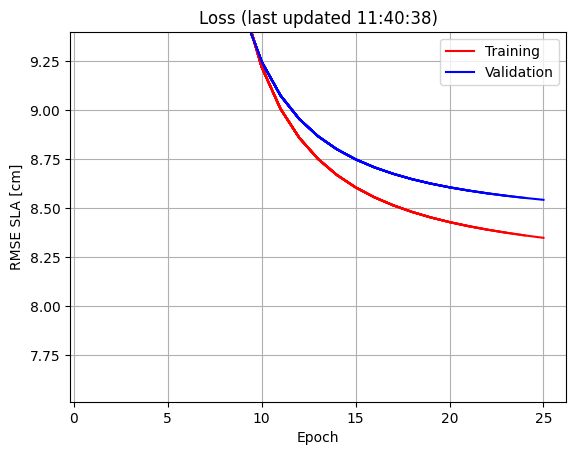

In [53]:
losses = TrainingLoop.train_validation_loop(
    model.to(DEVICE),
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    epochs,
    start_epoch,
    DEVICE,
    setup_plot_on_epoch(),
    SAVEFOLDER,
    save_every,
    dataset_parameters,
)

# Inference

In [54]:
# Make predictions
loader = validation_loader
loader_name = "validation"
outputs, targets, target_times = TrainingLoop.predict(model, loader, frame_size, DEVICE)
target_times = (np.array([0], dtype="datetime64[ns]") + target_times.astype("timedelta64[D]")).astype("datetime64[D]")

In [55]:
pred_title_multi = f"{dataset_parameters.prediction_steps} days predictions using {dataset_parameters.sequence_length} day(s) of data\nwith {dataset_parameters.sequence_steps - 1} day(s) inbetween"
pred_title = pred_title_multi.replace('\n', ' ')

In [56]:
diffs: _types.float_like = targets - outputs
rmses = np.full(diffs.shape[1:], np.nan)
for lat_idx in range(targets.shape[1]):
    for lon_idx in range(targets.shape[2]):
        pixel_diffs = diffs[:, lat_idx, lon_idx]
        pixel_diffs_nonan = pixel_diffs[~np.isnan(pixel_diffs)]
        if len(pixel_diffs_nonan) == 0:
            continue
        rmses[lat_idx, lon_idx] = np.sqrt(pixel_diffs_nonan @ pixel_diffs_nonan/len(pixel_diffs_nonan))

In [68]:
_colors

{'tab:blue': '#1f77b4',
 'tab:green': '#2ca02c',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [57]:
extent = [lon[0].min(), lon[0].max(), lat[:,0].min(), lat[:,0].max()]
_colors = mcolors.TABLEAU_COLORS.copy()
del _colors['tab:red']
del _colors['tab:orange']
del _colors['tab:purple']
del _colors['tab:brown']
del _colors['tab:pink']

colors = list(_colors.values())

## One sample comparisions (World)

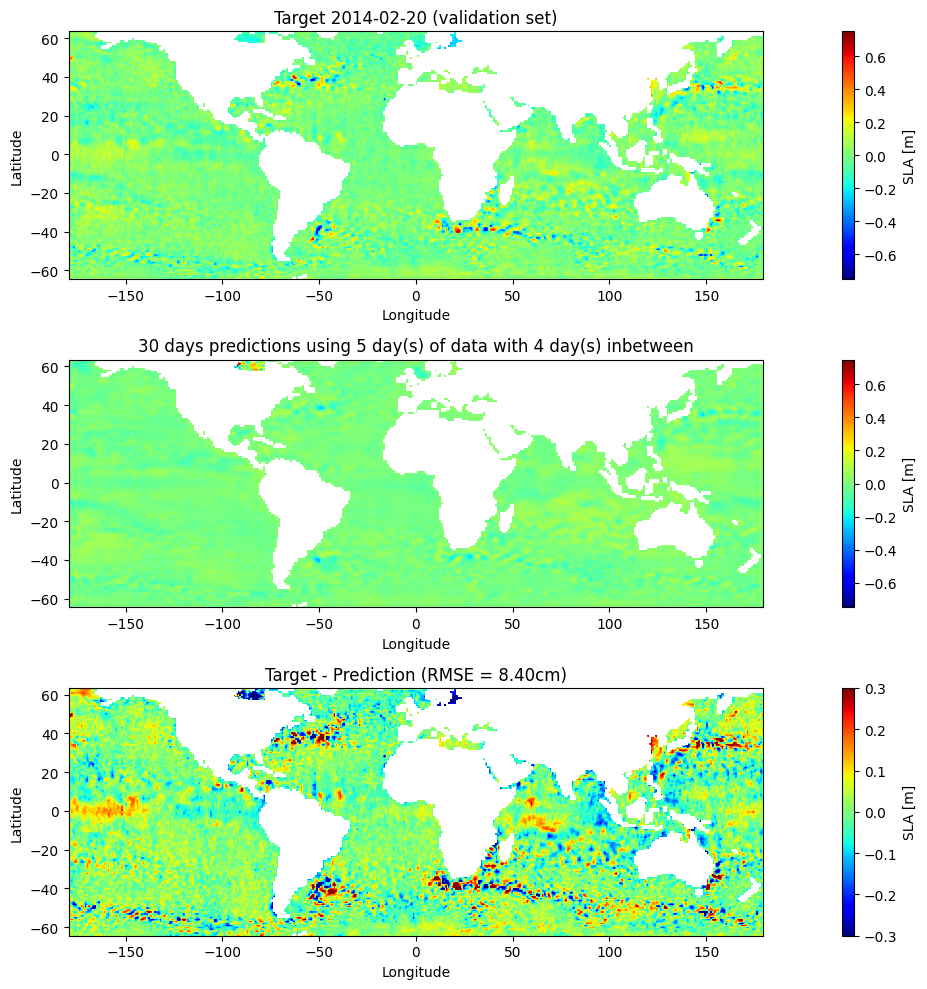

In [58]:
idx = 0
vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diff_data = diffs[idx]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(targets[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(outputs[idx], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx]} ({loader_name} set)")
axes[1].set_title(pred_title)
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()

## One sample comparisions (Timeseries)

In [65]:
i_fig

2

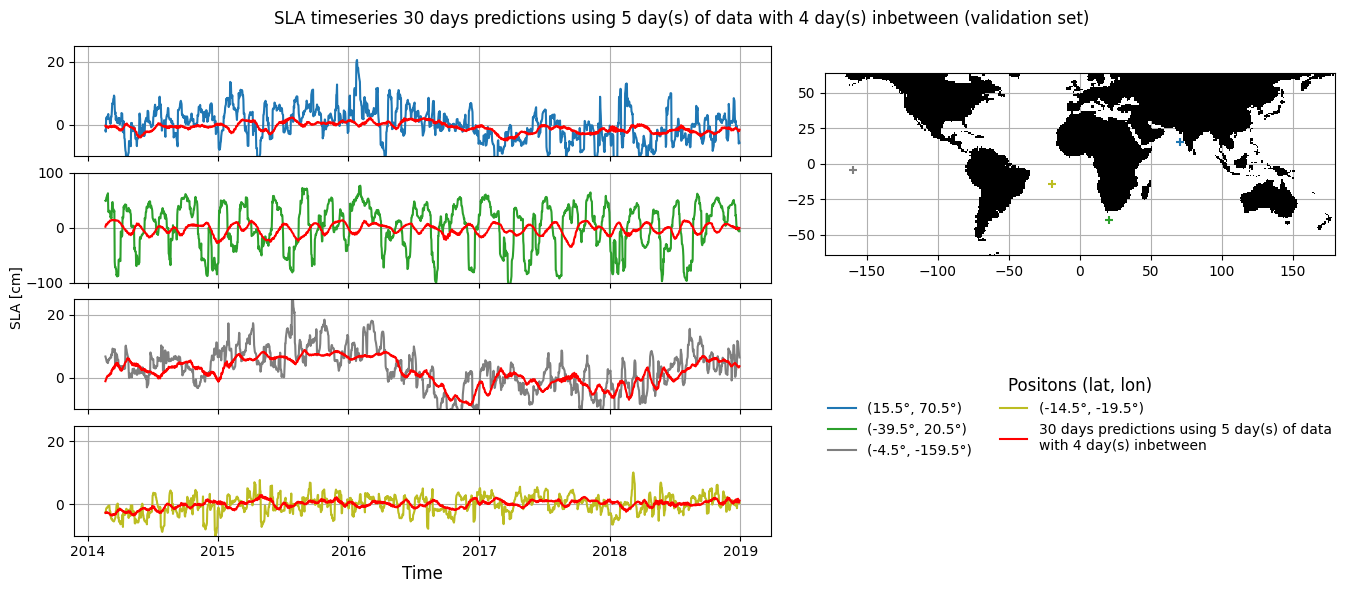

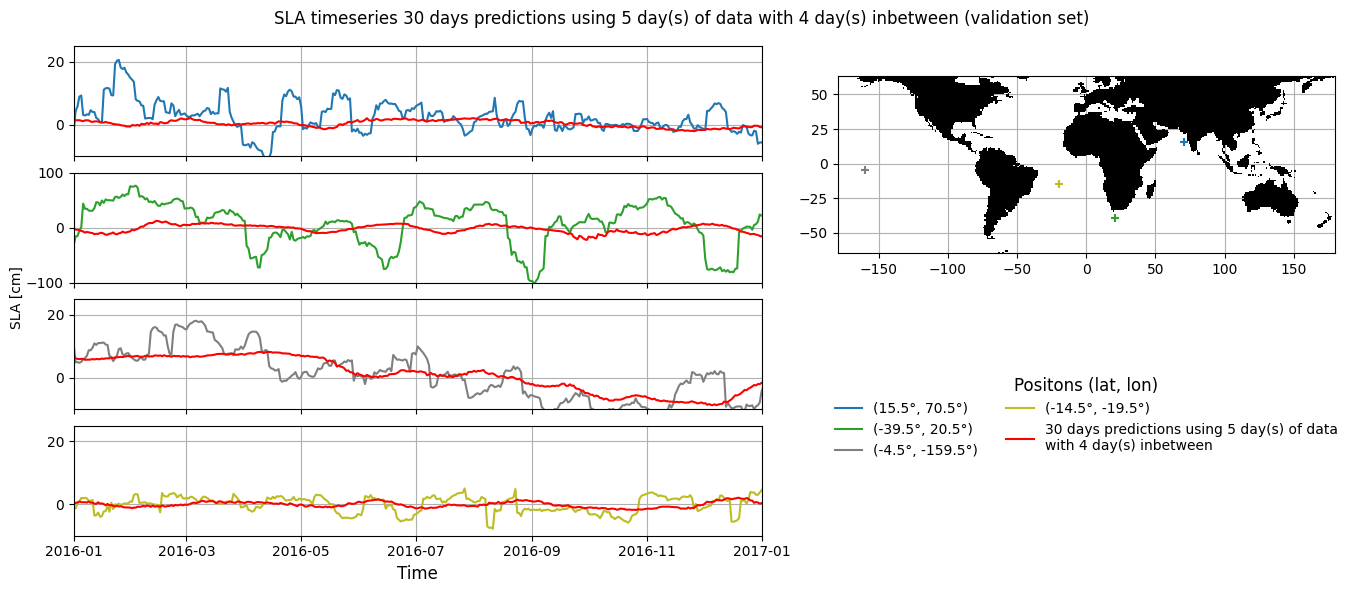

In [66]:
index_lats = (80, 25, 60, 50)
index_lons = (250, 200, 20, 160)
if len(index_lats) != len(index_lons):
    raise ValueError("Lat and lon indexes should have the same lenght")

n_rows = len(index_lats)
time_series_col = 4
map_col = 3
map_row = 2
vmin = (-10, -100, -10, -10)
vmax = (25, 100, 25, 25)

# Creates a nw figure for each xlim.
xlims = (
    (None, None),
    (np.datetime64("2016-01-01"), np.datetime64("2017-01-01"))
)

# Setup figures
if isinstance(xlims[0], (list, tuple)):
    n_figues = len(xlims)
else:
    n_figures = 1

# Get vlim
if isinstance(vmin, (list, tuple)):
    _vmin = vmin
else:
    _vmin = [vmin] * n_rows
if isinstance(vmax, (list, tuple)):
    _vmax = vmax
else:
    _vmax = [vmax] * n_rows

# Get xlim
if isinstance(xlims, (list, tuple)):
    _xlim = xlims
else:
    _xlim = (xlims, )
n_figures = len(_xlim)
    
for i_fig in range(n_figures):
    fig = plt.figure(constrained_layout=False, figsize=(14,1.5*n_rows))
    gs = GridSpec(n_rows, time_series_col + map_col, figure=fig)

    # Save legend
    lines, legend_name = [], []

    # coastline
    coastline = (~np.isnan(targets[0])).copy().astype(float)
    coastline[coastline == 1] = np.nan
    ax_coast = fig.add_subplot(gs.new_subplotspec((0, time_series_col), colspan=map_col, rowspan=map_row))
    ax_coast.imshow(coastline, origin='lower', cmap='gray', interpolation='None', extent=extent, zorder=10)
    ax_coast.grid(zorder=0)

    for i, (index_lat, index_lon, color) in enumerate(zip(index_lats, index_lons, colors)):           
        # Plot position on map
        lon_plot = lon[0, index_lon]
        lat_plot = lat[index_lat, 0]
        ax_coast.scatter(lon_plot, lat_plot, color=color, marker='+', zorder=20)

        # Timeseries
        ax = fig.add_subplot(gs.new_subplotspec((i, 0), colspan=time_series_col))
        lines.extend(ax.plot(target_times, targets[:, index_lat, index_lon] * 100, color=color))
        pred_lines = ax.plot(target_times, outputs[:, index_lat, index_lon] * 100, color='red')
        ax.set_ylim(_vmin[i], _vmax[i])
        ax.set_xlim(*_xlim[i_fig])
        ax.grid()

        # Name for legend
        legend_name.append(f"({lat_plot:.1f}\N{DEGREE SIGN}, {lon_plot:.1f}\N{DEGREE SIGN})")

        # Same xticks
        if i != n_rows - 1:
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            ax.set_xlabel("Time", fontsize=12)

    # Create legend
    lines.extend(pred_lines)
    legend_name.append(pred_title_multi)
    ax_legend = fig.add_subplot(gs.new_subplotspec((map_row, time_series_col), colspan=map_col, rowspan=n_rows - map_row))
    ax_legend.legend(lines, legend_name, loc='center', fancybox=False, title="Positons (lat, lon)", title_fontsize=12 , ncols=2, frameon=False, shadow=False)
    ax_legend.axis('off')

    fig.supylabel("SLA [cm]", fontsize=10)
    fig.suptitle(f"SLA timeseries {pred_title} ({loader_name} set)")
    fig.tight_layout()
    fig.subplots_adjust(hspace=.15)
    fig.show()

## RMSE average temporal

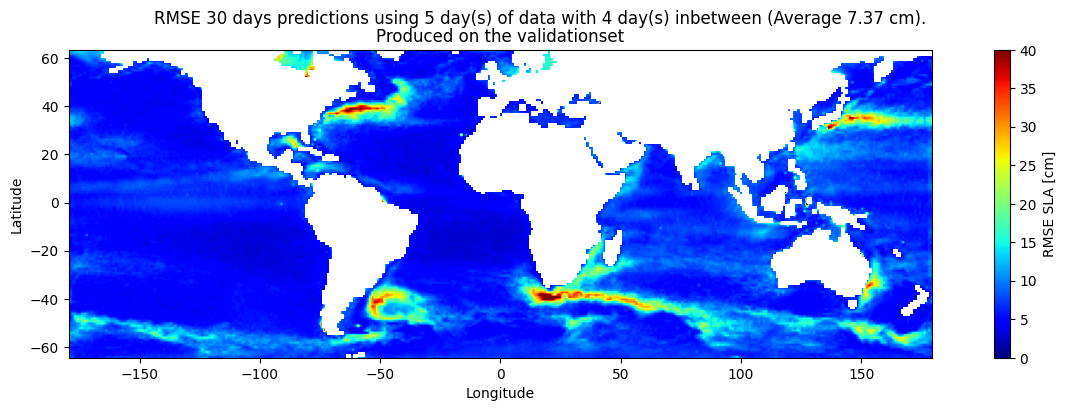

In [67]:
vmin = 0
vmax = 40
cmap = 'jet'

fig, ax = plt.subplots(1, 1, figsize=(16,4))
im_rms = ax.imshow(rmses * 100, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
fig.suptitle(f"RMSE {pred_title} (Average {np.nanmean(rmses)*100:.2f} cm).")
ax.set_title(f"Produced on the {loader_name}set")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
cax = fig.colorbar(im_rms)
cax.ax.set_ylabel("RMSE SLA [cm]")
plt.show()

## Global trends

In [60]:
loaders = [train_loader, validation_loader, test_loader]
loader_names = ["train", "validation", "test"]
outputs_all_list, targets_all_list, target_times_all_list, loader_id = [], [], [], []
for i, loader in enumerate(tqdm(loaders)):
    _outputs, _targets, _target_times = TrainingLoop.predict(model, loader, frame_size, DEVICE)
    _target_times = (np.array([0], dtype="datetime64[ns]") + _target_times.astype("timedelta64[D]")).astype("datetime64[D]")
    outputs_all_list.append(_outputs)
    targets_all_list.append(_targets)
    target_times_all_list.append(_target_times)
    loader_id.extend([i]*len(_target_times))
loader_id = np.array(loader_id)
targets_all = np.vstack(targets_all_list)
outputs_all = np.vstack(outputs_all_list)
target_times_all = np.hstack(target_times_all_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.37s/it]


In [61]:
lat_weighting = np.cos(lat * np.pi/180)
targets_weighted = targets_all * lat_weighting
outputs_weighted = outputs_all * lat_weighting
targets_mean_time = np.nanmean(targets_weighted, axis=(1,2))
outputs_mean_time = np.nanmean(outputs_weighted, axis=(1,2))

/tmp/ipykernel_4461/3172845263.py:4: RuntimeWarning: Mean of empty slice
  targets_mean_time = np.nanmean(targets_weighted, axis=(1,2))
/tmp/ipykernel_4461/3172845263.py:5: RuntimeWarning: Mean of empty slice
  outputs_mean_time = np.nanmean(outputs_weighted, axis=(1,2))


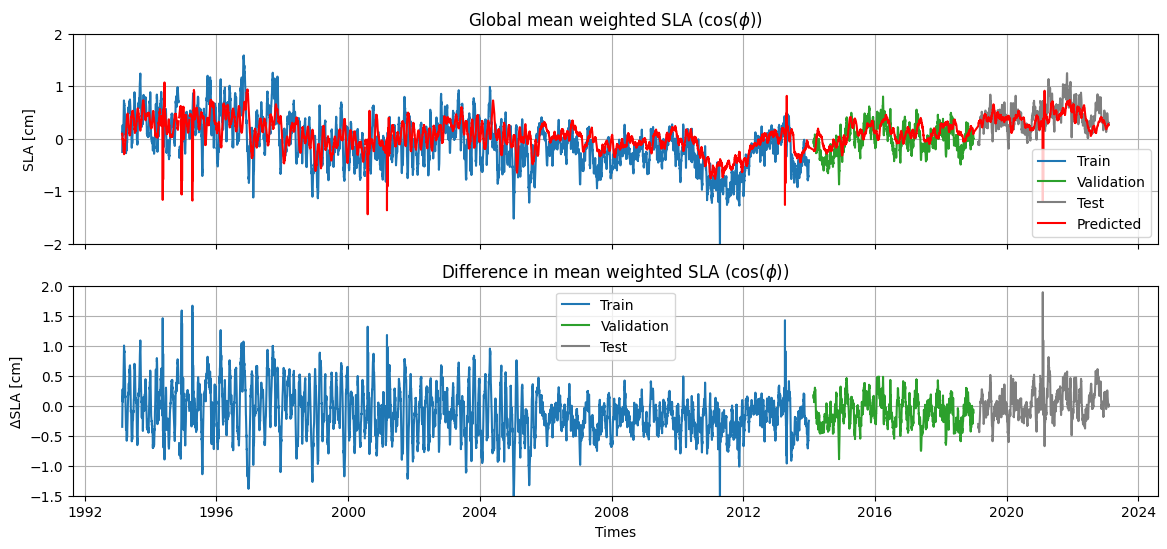

In [64]:
fig, (ax_raw, ax_diff) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
# Plot the difference splits
for i in np.unique(loader_id):
    bool_arr = loader_id == i
    ax_raw.plot(target_times_all[bool_arr], targets_mean_time[bool_arr] * 100, color=colors[i], label=loader_names[i].title())
    ax_diff.plot(target_times_all[bool_arr], (targets_mean_time - outputs_mean_time)[bool_arr] * 100, color=colors[i], label=loader_names[i].title())
ax_raw.plot(target_times_all, outputs_mean_time * 100, color='red', label="Predicted")

ax_raw.legend()
ax_raw.set_title("Global mean weighted SLA ($\cos(\phi)$)")
ax_raw.set_ylabel("SLA [cm]")
ax_raw.grid()
ax_raw.set_ylim(-2, 2)

ax_diff.legend()
ax_diff.set_title("Difference in mean weighted SLA ($\cos(\phi)$)")
ax_diff.set_xlabel("Times")
ax_diff.set_ylabel("ΔSLA [cm]")
ax_diff.grid(which='both')
ax_diff.set_ylim(-1.5, 2)
plt.show()